# dSprites - Disentanglement testing Sprites dataset

**Description**: In this notebook, we will load and explore the datasets. We will also replicate the experiments shown in the CME paper.

**Details**: The dSprite dataset consists of 2D shapes procedurally generated from 6 ground truth independent latent factors: *color (1 possible value), shape (3 possible values), scale (6), rotation (40), x (32) and y (32) positions of a sprite*. All possible combinations of these latents are present exactly once generating 737,280 total images shown in the dataset.

**Notes**: see [dSprites](https://github.com/deepmind/dsprites-dataset) for more details.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, plot_confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from tensorflow.python.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


# Change figure aesthetics
%matplotlib inline
# sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 1.5})

## Utilities

Contains helper functions.

In [2]:
def get_latent_sizes():
    """
    Get the size of each concept (see details above).
    """
    
    return np.array([1, 3, 6, 40, 32, 32])

def get_latent_bases():
    """
    Given vector (x, y, z) where each dimension is in base (a, b, c).
    The following function will convert each of (x, y, z) dimensions to decimal.
    """
    
    latent_sizes = get_latent_sizes()
    latent_bases = np.concatenate((latent_sizes[::-1].cumprod()[::-1][1:],
                                np.array([1,])))
    
    return latent_bases

In [3]:
def sample_latent(size=1):
    """
    Used to randomly sample latent of size 'size'
    """
    
    latents_sizes = get_latent_sizes()
    samples = np.zeros((size, len(latents_sizes)))
    for lat_i, lat_size in enumerate(latents_sizes):
        samples[:, lat_i] = np.random.randint(lat_size, size=size)

    return samples

In [4]:
def latent_to_index(latents):
    """
    Convert from given latent to index position of it in the dataset
    """
    
    latents_bases = get_latent_bases()
    return np.dot(latents, latents_bases).astype(int)

In [5]:
def show_images_grid(imgs_, num_images=25):
    """
    Used to visualise dSprite image in a grid
    """
    
    ncols = int(np.ceil(num_images**0.5))
    nrows = int(np.ceil(num_images / ncols))
    _, axes = plt.subplots(ncols, nrows, figsize=(nrows * 3, ncols * 3))
    axes = axes.flatten()
    
    # Draw images on the given grid
    for ax_i, ax in enumerate(axes):
        if ax_i < num_images:
            ax.imshow(imgs_[ax_i], cmap='Greys_r',  interpolation='nearest')
            ax.set_xticks([])
            ax.set_yticks([])
        else:
            ax.axis('off')

## Exploring dSprites

In this section, we will load and visualise the dSprite datasets.

### Load dataset

In [6]:
# Load dataset (the zip file)
dataset_zip = np.load('dsprites_ndarray_co1sh3sc6or40x32y32_64x64.npz')

# Extract relevant datas from the zip file
imgs = dataset_zip["imgs"] # contains image data (737280 x 64 x 64)
latents_values = dataset_zip['latents_values'] # values of latent factors (or in this case concepts)
latents_classes = dataset_zip['latents_classes'] # classification targets (integer index of latents_values)

### Draw samples

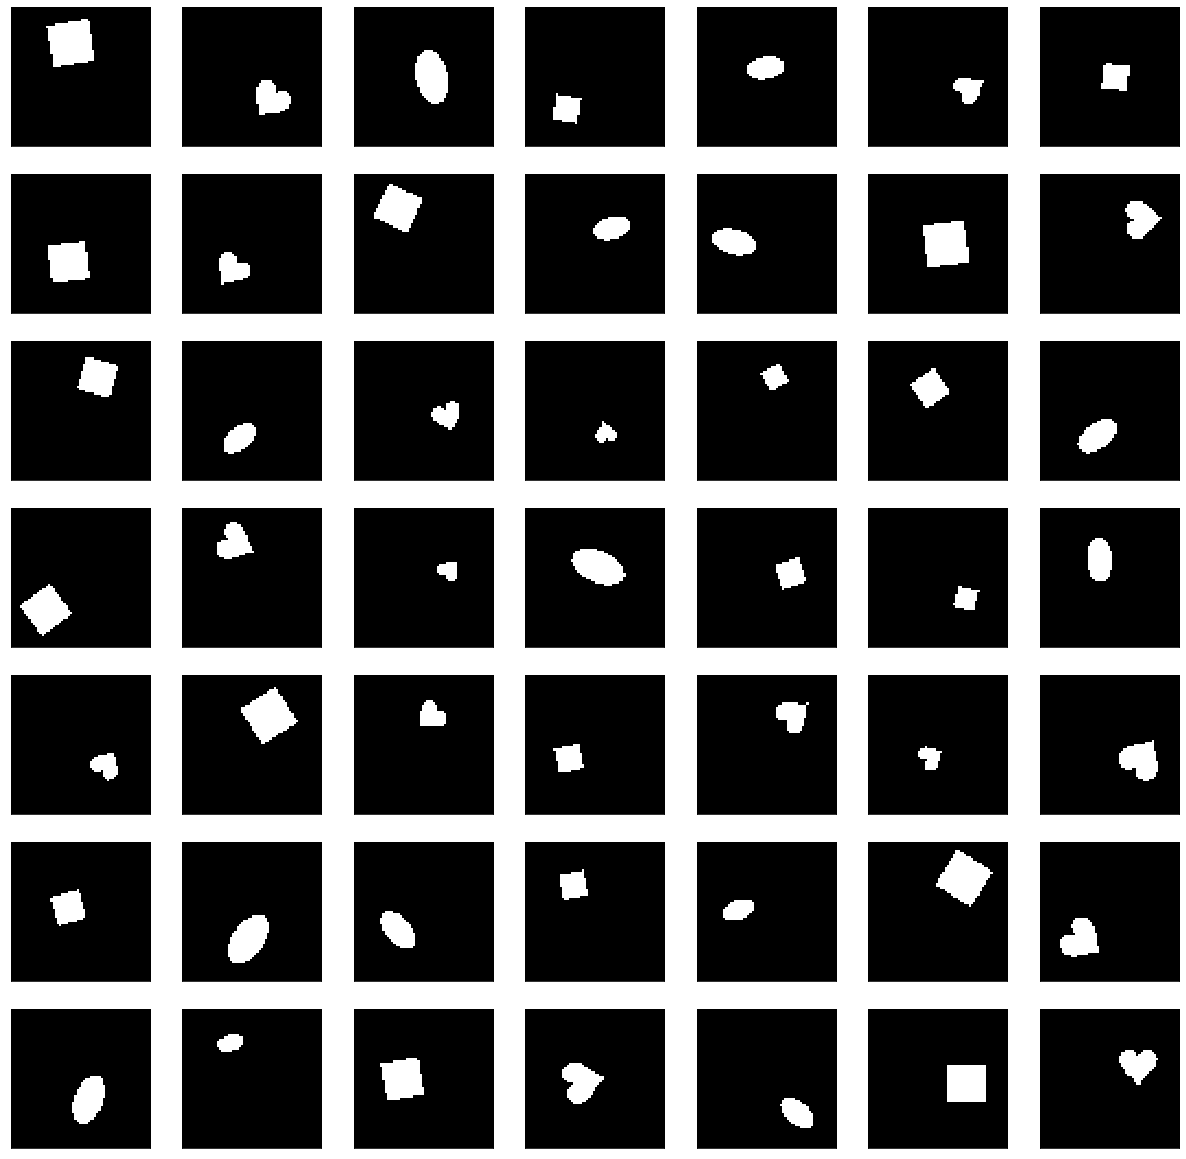

In [7]:
# Randomly sample some latents (from the dataset)
latents_sampled = sample_latent(size=49)

# Select images
indices_sampled = latent_to_index(latents_sampled)
imgs_sampled = imgs[indices_sampled]

# Show images
show_images_grid(imgs_sampled, num_images=49)

### Splitting Training/ Testing Set

In [8]:
concept_names = ['color', 'shape', 'scale', 'rotation', 'x_pos', 'y_pos']
class_index = 1 # shape

X = imgs # image
X = np.expand_dims(X, axis=-1)
X = X.astype(('float32'))
y = latents_classes[:, class_index] # shape for task 1
c = latents_classes # concepts

# Split X (image), y (shape for task 1), concepts to train test sets
X_train, X_test, y_train, y_test, c_train, c_test = train_test_split(X, y, c, train_size=0.85)
print('Training samples:', X_train.shape[0])
print('Testing samples:', X_test.shape[0])

Training samples: 626688
Testing samples: 110592


## Input to Concept Model

In this section, we will train input to concept model. The input to concept model will take an image and output concepts.

In [13]:
def build_input_to_concept_model():
    """
    Build and return multi-task model.
    """
        
    img_inputs = tf.keras.Input(shape=(64,64,1))
    
    # Shared layers
    x = Conv2D(64, (8, 8), strides=(2, 2), padding='same')(x)
    x = Dropout(0.3)(x)
    
    x =  Conv2D(128, (6, 6), strides=(2, 2), padding='valid')(x)
    x = BatchNormalization()(x)
    
    x = Conv2D(128, (5, 5), strides=(1, 1), padding='valid')(x)
    x = MaxPooling2D((2, 2))(x)
    x = Dropout(0.3)(x)
    
    x = Flatten()(x)
    x = Dense(128, activation="relu")(x)
    x = Dropout(0.4)(x)
    x = Dense(64, activation="relu")(x)
    x = Dropout(0.2)(x)
    
    # Task specific layer
    task_color = Dense(1, activation="softmax")(x)
    task_shape = Dense(3, activation="softmax")(x)
    task_scale = Dense(6, activation="softmax")(x)
    task_rotation = Dense(40, activation="softmax")(x)
    task_x = Dense(32, activation="softmax")(x)
    task_y = Dense(32, activation="softmax")(x)
    
    optimizer = tf.keras.optimizers.Adam(lr=1e-4, amsgrad=True)
    model = tf.keras.Model(inputs=img_inputs, outputs=[task_color, task_shape, task_scale, task_rotation, task_x, task_y])
    model.compile(optimizer=optimizer,
                 loss={
                     "task_color": "categorical_crossentropy",
                     "task_shape": "categorical_crossentropy",
                     "task_scale": "categorical_crossentropy",
                     "task_rotation": "categorical_crossentropy",
                     "task_x": "categorical_crossentropy",
                     "task_y": "categorical_crossentropy",
                 })
    
    return model

In [ ]:
epochs = 10
batch_size = 128


model = build_input_to_concept_model()
history = model.fit(x=X_train, y=c_train, epochs=epochs, batch_size=batch_size)

In [ ]:
# Plot training-validation loss
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.grid(True)
plt.legend()
plt.show()

## Concept to Output Model

In this section, we will train concept to output model. The model will take concepts as input and shape as output.

In [ ]:
# Build and train model
com = DecisionTreeClassifier()
com.fit(c_train, y_train)

In [ ]:
y_test_pred = com.predict(c_test)
print(classification_report(y_test_pred, y_test))
plot_confusion_matrix(com, c_test, y_test)

## End to End Model

In this section, we will evaluate the performance of the model as a whole (merging input to concept and concept to output models).